### Ridge regression

In the last unit, we learned about 
L
2
 regularization and saw that it adds a constraint on the length of the vector of parameters w. So far, we didn’t specify any particular model or cost function, but if we use multi-linear regressions and minimize the squares of the residuals, we obtain the ridge regression model.

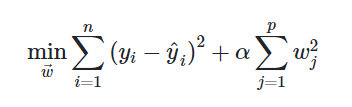

In [1]:
from IPython.display import Image
Image(filename="ridge.png")

In this unit, we will implement ridge regressions with Scikit-learn and test our model on a set of 50 noisy observations of a sine curve.

In [2]:
import pandas as pd

# Load the training data
training_data = pd.read_csv("c3_data-points.csv")

# Print shape
print("Shape:", training_data.shape)

# First five rows
training_data.head()

Shape: (50, 2)


,x,y
0,0.000,0.706
1,0.128,0.288
2,0.256,0.645
3,0.385,1.272
4,0.513,1.238


We generated the 50 x/y data points using a sine curve. The idea is to create 50 points on the curve and add a small noise to each point. Let’s create the x, y variables and plot the data. Note that in this unit we work only with the training set and for simplicity we use the names x, y instead of x_tr, y_tr.

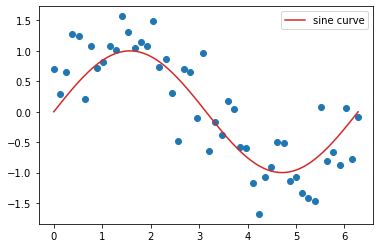

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y data
x = training_data.x.values
y = training_data.y.values

# Plot data points
plt.scatter(x, y)

# Plot sine curve for reference
x_values = np.linspace(min(x), max(x), num=100)
y_sine = np.sin(x_values)
plt.plot(x_values, y_sine, c="C3", label="sine curve")
plt.legend()
plt.show()

In this unit, we will try to recover this sine curve from the 50 noisy observations of it.

#### Polynomial regression
Let’s fit a polynomial regression of degree 10 to this set of points. We can generate the polynomial features using the PolynomialFeatures object from Scikit-learn.

In [5]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial features
poly_obj = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_obj.fit_transform(x[:, np.newaxis])

print("Shape:", X_poly.shape)
print("Features:", poly_obj.get_feature_names_out())

Shape: (50, 10)
Features: ['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']


Later in this unit, we will apply regularization to our models. Since regularization is sensitive to the scale of our features, we will start by standardizing our data.

This is a common operation in machine learning, so Scikit-learn implements a StandardScaler() object to do it. Let’s see how to use to it.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_poly)

In this code, we first have to create the object and then call its fit_transform() function to compute the mean/standard deviation of each feature (fit) and apply standardization (transform).

Important note: The scaler object has also a transform() function which does not compute the mean/standard deviation of a feature but only applies the transformation. However, since here we are working with the training data we should use fit_transform() function. Later in this course we will see that in order to only apply the standardization on the validation and testing data we should use the transform() function. This is because we shouldn’t learn the mean/standard deviation from the validation and testing data.

Let’s verify that the data is standardized. The mean should be close to zero.

In [7]:
X_rescaled.mean(axis=0)

array([ 1.77635684e-16,  2.66453526e-16, -1.68753900e-16, -8.88178420e-18,
       -7.99360578e-17,  8.88178420e-18, -1.77635684e-17, -1.77635684e-17,
        4.44089210e-17,  1.06581410e-16])

In [8]:
X_rescaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Let’s now fit a linear regression to the standardize data and plot its prediction curve.

In [9]:
from sklearn.linear_model import LinearRegression

# Linear regression
lr = LinearRegression()
lr.fit(X_rescaled, y)

# Pass sample x values through the preprocessing steps
# Create the polynomial basis with poly_obj.transform()
# Standardize the features with scaler.transform() to get the X_values_rescaled
X_values_rescaled = scaler.transform(poly_obj.transform(x_values[:, np.newaxis]))
y_values_lr = lr.predict(X_values_rescaled)

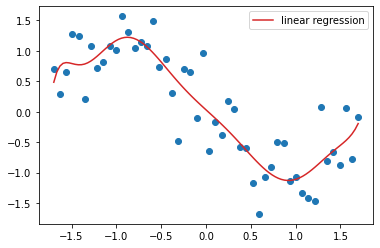

In [10]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_lr, c="C3", label="linear regression")
plt.legend()
plt.show()

As we can see, the model is clearly overfitting. Let’s try to reduce overfitting with regularization

#### Ridge regression
Scikit-learn implements ridge regressions with its Ridge object from the linear_model module. This object is an estimator which means that it implements the usual fit(), predict() and score() functions.


In [12]:
from sklearn.linear_model import Ridge

# Ridge regression
ridge = Ridge()
ridge.fit(X_rescaled, y)

# Compute predictions
y_values_ridge = ridge.predict(X_values_rescaled)

In this code, we replaced the LinearRegression object with a Ridge one. The rest of the code is the same. We get the following curve.



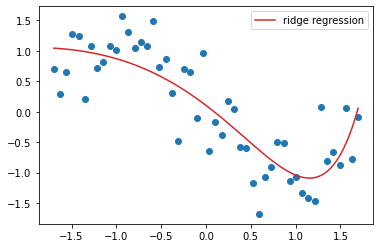

In [13]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_ridge, c="C3", label="ridge regression")
plt.legend()
plt.show()

By default, the Ridge object sets the regularization strength 
α
 to one. In our case, the curve is too rigid to model the data points, and the model is underfitting.

We can decrease the constraint on the coefficients by setting a lower alpha value.

In [14]:
# Ridge regression
ridge2 = Ridge(alpha=1e-4)
ridge2.fit(X_rescaled, y)

# Compute predictions
y_values_ridge2 = ridge2.predict(X_values_rescaled)

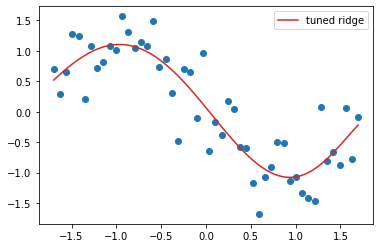

In [15]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_ridge2, c="C3", label="tuned ridge")
plt.legend()
plt.show()

We can also compare the coefficients before and after adding the regularization term using the coef_ attribute.

In [16]:
# Linear regression coefficients
features = poly_obj.get_feature_names_out()
for feature, coef in zip(features, lr.coef_):
    print("{:<6}: {:>10.1f}".format(feature, coef))

x0    :        6.3
x0^2  :     -156.5
x0^3  :     1604.8
x0^4  :    -8250.8
x0^5  :    24145.5
x0^6  :   -42951.3
x0^7  :    47245.0
x0^8  :   -31285.6
x0^9  :    11373.1
x0^10 :    -1731.0


In [17]:
# Ridge regression coefficients
for feature, coef in zip(features, ridge2.coef_):
    print("{:<6}: {:>4.1f}".format(feature, coef))

x0    :  1.4
x0^2  : -1.6
x0^3  : -6.8
x0^4  :  3.9
x0^5  :  4.5
x0^6  :  0.5
x0^7  : -1.7
x0^8  : -1.1
x0^9  :  0.2
x0^10 :  0.1


As we can see, the coefficients are much smaller with ridge regression than with linear regression.

Using the analogy from the previous unit, the coefficients of the linear regression model minimize the loss function L(w) in blue. On the other hand, the coefficients of the ridge regression model correspond to the optimal solution w*.


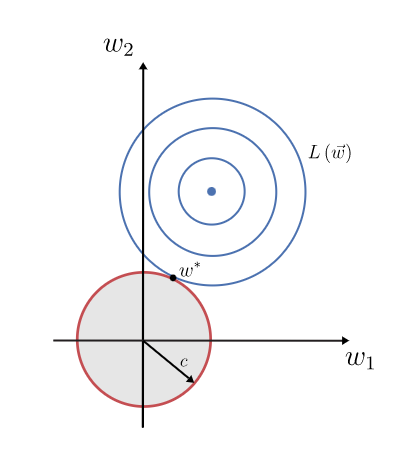

In [18]:
from IPython.display import Image
Image(filename="optimal.png")

In [ ]:
#### Lasso regressions
One of the advantages of using Scikit-learn is that it’s easy to test different estimators. For instance, we can change the regularization to 
L
1
 using the Lasso estimator.